In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Experiment: Linear

In [2]:
# pull things from the files!

n_draws = 500

sim_1 = pd.read_pickle('Data/PPC/exp_linear/sim_1.pkl')
n = len(sim_1)

ppc = np.zeros((n, n_draws))
for ii in range(n_draws):
    f = 'Data/PPC/exp_linear/sim_{}.pkl'.format(ii)
    ppc[:, ii] = pd.read_pickle(f)['arm_sim']
    

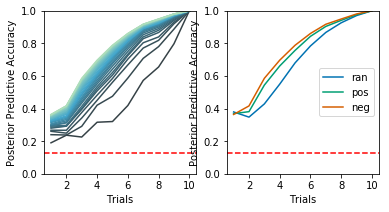

In [3]:
# does the model get better at predicting behavior across rounds?

def ppc_acc_v_round(ppc, raw):
    y_true = raw.arm

    df = []
    cc = sns.color_palette("GnBu_d", 31)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))


    # first plot
    ax = axes[0]
    for r in range(1, 31):
        for ii in range(n_draws):
            y_samp = ppc[:, ii] 
            df.append(raw.loc[(y_true == y_samp) & (raw['round'] == r), 'trial'].values)
        y = np.array([np.sum(np.concatenate(df) == ii) for ii in range(1, 11)], dtype=float)
        y /= y.max()
        ax.plot(range(1, 11), y, color=cc[r])
    ax.set_ylabel('Posterior Predictive Accuracy')
    ax.set_xlabel('Trials')
    ax.axhline(y=1./8, color='r', ls='dashed')
    ax.set_ylim([0, 1])


    # second plot
    df = []
    cc = sns.color_palette("colorblind")
    ax = axes[1]
    for jj, cond in enumerate(['ran', 'pos', 'neg']):
        for ii in range(n_draws):
            y_samp = ppc[:, ii] 
            df.append(raw.loc[(y_true == y_samp) & (raw['cond'] == cond), 
                                   'trial'].values)
        y = np.array([np.sum(np.concatenate(df) == ii) for ii in range(1, 11)], dtype=float)
        y /= y.max()
        ax.plot(range(1, 11), y, color=cc[jj], label=cond)
    ax.legend()
    ax.set_ylabel('Posterior Predictive Accuracy')
    ax.set_xlabel('Trials')
    ax.axhline(y=1./8, color='r', ls='dashed')
    ax.set_ylim([0, 1])
    
    return fig, axes

fig, axes = ppc_acc_v_round(ppc, sim_1)

# plt.savefig('Exp1_ppc_acc_by_time.png', dpi=300)
# plt.savefig('Exp1_ppc_acc_by_time.pdf', dpi=300)

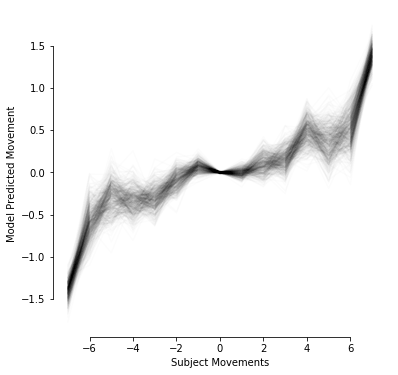

In [4]:
def model_pred_movement(ppc, raw):
    fig, ax = plt.subplots(figsize=(6, 6))

    for ii in range(n_draws):
        y_samp = ppc[:, ii]  
        y = raw.loc[:, 'arm'].values
        rew = raw.loc[:, 'out'].values[:-1]

        move_samp = y_samp[1:] - y_samp[:-1]
        move_true = y[1:] - y[:-1]

        move_samp = move_samp[raw.trial[1:] != 10]
        move_true = move_true[raw.trial[1:] != 10]

        movements = range(np.min(move_true), np.max(move_true)+1)
        model_movements = [np.mean(move_samp[move_true == v])for v in movements]
        model_movements_err = [np.std(move_samp[move_true == v]) for v in movements]

        plt.plot(movements, model_movements, alpha=0.01, color='k')
    # plt.xlim([-7.5, 7.5])
    # plt.ylim([-7.5, 7.5])
    plt.xlabel('Subject Movements')
    plt.ylabel('Model Predicted Movement')
    sns.despine(offset=0, trim=True)
    return fig, ax
fig, ax = model_pred_movement(ppc, sim_1)

# plt.savefig('Exp1_PPC_movement.png', dpi=300)
# plt.savefig('Exp1_PPC_movement.pdf', dpi=300)

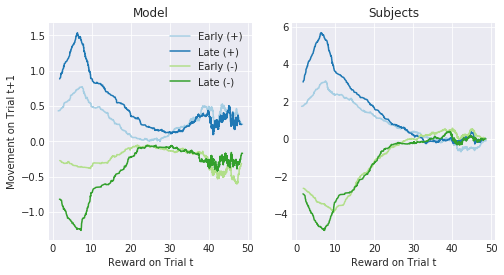

In [5]:
def plot_3(ppc, raw_data):
    y_true = raw_data.arm
    cc = sns.color_palette('colorblind')
    
    with sns.axes_style('darkgrid'):
        
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        # def smooth(y, sigma=2):
        #     gx = np.arange(-3*sigma, 3*sigma, 0.1)
        #     gaussian = np.exp(-(x/sigma)**2/2)
        #     y_smooth = np.convolve(y, gaussian, mode='same')
        #     return y_smooth

        def smooth(y, box_pts):
            box = np.ones(box_pts)/box_pts
            y_smooth = np.convolve(y, box, mode='same')
            return y_smooth

        def plot_sample_early(ax, cond, color=cc, label=None):

            all_preds = []
            for ii in range(n_draws):
                y_samp = ppc[:, ii]
                y = raw_data.loc[:, 'arm'].values
                rew = raw_data.loc[:, 'out'].values[:-1]

                move_samp = y_samp[1:] - y_samp[:-1]

                vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == cond) & (raw_data['round'][1:] <= 5)

                move_samp = move_samp[vec]
                rew = rew[vec]

                idx = np.argsort(rew)
                x = rew[idx]
                y = smooth(move_samp[idx], 200)

                all_preds.append(y)
            ax.plot(x, np.array(all_preds).mean(axis=0), color=color, label=label)

        def plot_sample_late(ax, cond, color=cc, label=None):

            all_preds = []
            for ii in range(n_draws):
                y_samp = ppc[:, ii]
                y = raw_data.loc[:, 'arm'].values
                rew = raw_data.loc[:, 'out'].values[:-1]

                move_samp = y_samp[1:] - y_samp[:-1]

                vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == cond) & (raw_data['round'][1:] > 20)

                move_samp = move_samp[vec]
                rew = rew[vec]

                idx = np.argsort(rew)
                x = rew[idx]
                y = smooth(move_samp[idx], 200)

                all_preds.append(y)
            ax.plot(x, np.array(all_preds).mean(axis=0), color=color, label=label)

        cc = sns.color_palette("Paired")
        plot_sample_early(axes[0], 'pos', color=cc[0], label='Early (+)')
        plot_sample_late(axes[0], 'pos', color=cc[1], label='Late (+)')

        plot_sample_early(axes[0], 'neg', color=cc[2], label='Early (-)')
        plot_sample_late(axes[0], 'neg', color=cc[3], label='Late (-)')
        axes[0].legend()
        axes[0].set_title('Model')
        axes[0].set_xlabel('Reward on Trial t')
        axes[0].set_ylabel('Movement on Trial t+1')


        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'pos') & (raw_data['round'][1:] <= 5)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x = rew[idx]
        y = smooth(move_true[idx], 200)
        axes[1].plot(x, y, color=cc[0], label='Early (+)')

        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'pos') & (raw_data['round'][1:] > 20)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x = rew[idx]
        y = smooth(move_true[idx], 200)
        axes[1].plot(x, y, color=cc[1], label='Late (+)')


        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'neg') & (raw_data['round'][1:] <= 5)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x = rew[idx]
        y = smooth(move_true[idx], 200)
        axes[1].plot(x, y, color=cc[2], label='Early (-)')

        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'neg') & (raw_data['round'][1:] > 20)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x = rew[idx]
        y = smooth(move_true[idx], 200)
        axes[1].plot(x, y, color=cc[3], label='Late (-)')

        axes[1].set_xlabel('Reward on Trial t')
        axes[1].set_title('Subjects')

    return fig, axes
fig, axes = plot_3(ppc, sim_1)

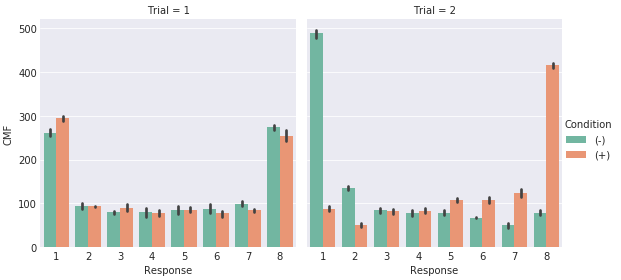

In [6]:
# what is the distribution of choices on trials 1 and 2 for the pos and neg conditions?

def plot_4(ppc, raw_data):

    y = raw_data.loc[:, 'arm'].values

    samples = 5

    def get_cmf(cond, trial=1):
        all_preds = []
        for ii in range(samples):
            y_samp = ppc[:, ii]

            vec = (raw_data.trial == trial) & (raw_data.cond == cond)
            y_samp = y_samp[vec]
            all_preds.append([np.sum(np.array(y_samp) == ii) for ii in range(1, 9)])

        all_preds = np.array(all_preds, dtype=float) #/ np.sum(all_preds, axis=0)
        return all_preds

    df = pd.concat([pd.DataFrame({
        'CMF': get_cmf('neg').reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(-)'] * 8 * samples,
        'Trial': [1] * 8 * samples 
    }), pd.DataFrame({
        'CMF': get_cmf('pos').reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(+)'] * 8 * samples,
        'Trial': [1] * 8 * samples 
    }), pd.DataFrame({
        'CMF': get_cmf('neg', 2).reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(-)'] * 8 * samples,
        'Trial': [2] * 8 * samples 
    }), pd.DataFrame({
        'CMF': get_cmf('pos', 2).reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(+)'] * 8 * samples,
        'Trial': [2] * 8 * samples 
    })])

    with sns.axes_style('darkgrid'):
        g = sns.factorplot(data=df, x='Response', y='CMF', hue='Condition', kind='bar', 
                       col='Trial', palette=sns.color_palette("Set2"))
    return g

g = plot_4(ppc, sim_1)

# Experiment: Shifted

In [7]:
# pull things from the files!

# n_draws = 500

sim_1 = pd.read_pickle('Data/PPC/exp_shifted/sim_1.pkl')
n = len(sim_1)

ppc = np.zeros((n, n_draws))
for ii in range(n_draws):
    f = 'Data/PPC/exp_shifted/sim_{}.pkl'.format(ii)
    ppc[:, ii] = pd.read_pickle(f)['arm_sim']
    

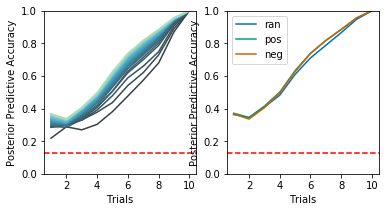

In [8]:
fig, axes = ppc_acc_v_round(ppc, sim_1)

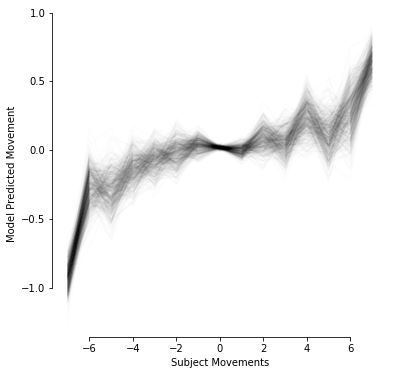

In [9]:
fig, ax = model_pred_movement(ppc, sim_1)

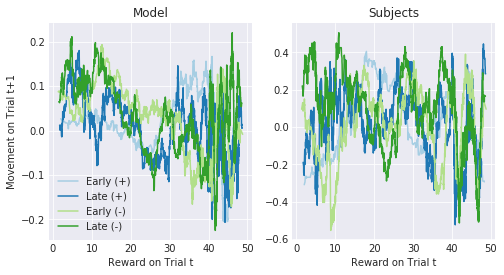

In [10]:
fig, axes = plot_3(ppc, sim_1)

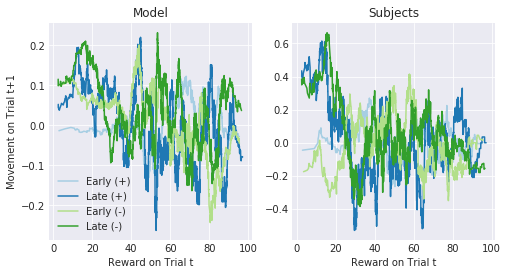

In [11]:
def plot_3(ppc, raw_data, intercept=False):
    box_points = 200
    
    y_true = raw_data.arm
    cc = sns.color_palette('colorblind')
    
    with sns.axes_style('darkgrid'):
        
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        # def smooth(y, sigma=2):
        #     gx = np.arange(-3*sigma, 3*sigma, 0.1)
        #     gaussian = np.exp(-(x/sigma)**2/2)
        #     y_smooth = np.convolve(y, gaussian, mode='same')
        #     return y_smooth

        def smooth(y, box_pts):
            box = np.ones(box_pts)/box_pts
            y_smooth = np.convolve(y, box, mode='same')
            return y_smooth

        def plot_sample_early(ax, cond, color=cc, label=None):

            all_preds = []
            for ii in range(n_draws):
                y_samp = ppc[:, ii]
                y = raw_data.loc[:, 'arm'].values
                rew = raw_data.loc[:, 'out'].values[:-1]
                if intercept:
                    rew = raw_data.loc[:, 'out'].values[:-1] + \
                        raw_data.loc[:, 'int'].values[:-1]

                move_samp = y_samp[1:] - y_samp[:-1]

                vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == cond) & (raw_data['round'][1:] <= 5)

                move_samp = move_samp[vec]
                rew = rew[vec]

                idx = np.argsort(rew)
                x = rew[idx]
                y = smooth(move_samp[idx], box_points)

                all_preds.append(y)
            ax.plot(x, np.array(all_preds).mean(axis=0), color=color, label=label)

        def plot_sample_late(ax, cond, color=cc, label=None):

            all_preds = []
            for ii in range(n_draws):
                y_samp = ppc[:, ii]
                y = raw_data.loc[:, 'arm'].values
                rew = raw_data.loc[:, 'out'].values[:-1]
                if intercept:
                    rew = raw_data.loc[:, 'out'].values[:-1] + \
                        raw_data.loc[:, 'int'].values[:-1]

                move_samp = y_samp[1:] - y_samp[:-1]

                vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == cond) & (raw_data['round'][1:] > 20)

                move_samp = move_samp[vec]
                rew = rew[vec]

                idx = np.argsort(rew)
                x = rew[idx]
                y = smooth(move_samp[idx], box_points)

                all_preds.append(y)
            ax.plot(x, np.array(all_preds).mean(axis=0), color=color, label=label)

        cc = sns.color_palette("Paired")
        plot_sample_early(axes[0], 'pos', color=cc[0], label='Early (+)')
        plot_sample_late(axes[0], 'pos', color=cc[1], label='Late (+)')

        plot_sample_early(axes[0], 'neg', color=cc[2], label='Early (-)')
        plot_sample_late(axes[0], 'neg', color=cc[3], label='Late (-)')
        axes[0].legend()
        axes[0].set_title('Model')
        axes[0].set_xlabel('Reward on Trial t')
        axes[0].set_ylabel('Movement on Trial t+1')


        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        if intercept:
            rew = raw_data.loc[:, 'out'].values[:-1] + \
                raw_data.loc[:, 'int'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'pos') & (raw_data['round'][1:] <= 5)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x = rew[idx]
        y = smooth(move_true[idx], box_points)
        axes[1].plot(x, y, color=cc[0], label='Early (+)')

        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        if intercept:
            rew = raw_data.loc[:, 'out'].values[:-1] + \
                raw_data.loc[:, 'int'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'pos') & (raw_data['round'][1:] > 20)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x = rew[idx]
        y = smooth(move_true[idx], box_points)
        axes[1].plot(x, y, color=cc[1], label='Late (+)')


        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        if intercept:
            rew = raw_data.loc[:, 'out'].values[:-1] + \
                raw_data.loc[:, 'int'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'neg') & (raw_data['round'][1:] <= 5)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x = rew[idx]
        y = smooth(move_true[idx], box_points)
        axes[1].plot(x, y, color=cc[2], label='Early (-)')

        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        if intercept:
            rew = raw_data.loc[:, 'out'].values[:-1] + \
                raw_data.loc[:, 'int'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'neg') & (raw_data['round'][1:] > 20)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x = rew[idx]
        y = smooth(move_true[idx], box_points)
        axes[1].plot(x, y, color=cc[3], label='Late (-)')

        axes[1].set_xlabel('Reward on Trial t')
        axes[1].set_title('Subjects')

    return fig, axes
fig, axes = plot_3(ppc, sim_1, True)

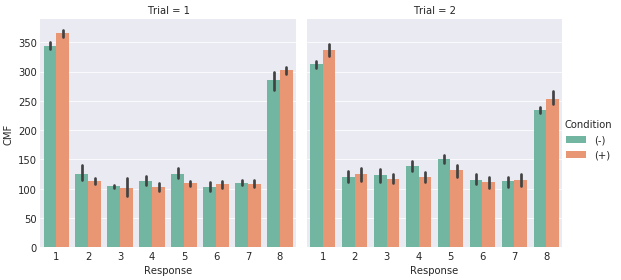

In [12]:
g = plot_4(ppc, sim_1)